In [1]:
%matplotlib notebook
# starter code
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
from graph_tool.all import load_graph, shortest_distance, GraphView, shortest_path
from networkx.drawing.nx_agraph import graphviz_layout

from cascade import gen_nontrivial_cascade
from utils import get_rank_index, extract_edges

seed = 123456
random.seed(seed)
np.random.seed(seed)

gtype = 'grid'
g = load_graph('data/{}/2-6/graph.gt'.format(gtype))
gnx = nx.read_graphml('data/{}/2-6/graph.graphml'.format(gtype))
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
N1, N2 = 100, 100
p, q = 0.5, 0.5

pos = graphviz_layout(gnx, root=0)

In [2]:
from steiner_tree_order import remove_redundant_edges_from_tree, temporal_bfs
from steiner_tree_mst import extract_edges_from_pred, init_visitor

In [30]:
from graph_tool import Graph
from graph_tool.search import pbfs_search, cpbfs_search

def temporal_bfs(g, r, D, infection_times, source, obs_nodes, debug=False):
    """return the tree covering obs_nodes"""
    queue = [r]
    t_lower = np.ones(g.num_vertices(), dtype=np.int32) * -1  # hidden nodes has lower bound -1
    t_lower[obs_nodes] = infection_times[obs_nodes]
    t_lower[r] = D
    visited = np.zeros(g.num_vertices(), dtype=bool)
    tree_edges = []
    while len(queue) > 0 and np.any(visited[obs_nodes] == 0):
        v = queue.pop(0)

        if debug:
            print('visiting {}'.format(v))

        visited[v] = True
        for u in g.vertex(v).all_neighbours():
            u = int(u)
            if debug:
                print('trying its nbr {}'.format(u))

            if visited[u] == 0:
                if debug:
                    print('{} is not visited'.format(u))
                    print('t_l[{}]={}, t_l[{}]={}'.format(u, t_lower[u],
                                                         v, t_lower[v]))
                visitable = False

                if t_lower[u] >= t_lower[v]:
                    if debug:
                        print('first case')
                    visitable = True

                if t_lower[u] == -1:
                    if debug:
                        print('second case')
                    visitable = True
                    t_lower[u] = t_lower[v]

                if visitable:
                    if debug:
                        print('add {} to queue'.format(u))
                    queue.append(u)
                    tree_edges.append((v, u))
                    visited[u] = True

    t = Graph(directed=True)
    for _ in range(g.num_vertices()):
        t.add_vertex()

    for u, v in tree_edges:
        t.add_edge(t.vertex(u), t.vertex(v))
                    
    vis = init_visitor(t, root)
    pbfs_search(t, source=root, terminals=list(obs_nodes), visitor=vis)

    minimum_edges = {e
                     for u in obs_nodes
                     for e in extract_edges_from_pred(t, root, u, vis.pred)}

    efilt = t.new_edge_property('bool')
    efilt.a = False
    for u, v in minimum_edges:
        efilt[u, v] = True
    t.set_edge_filter(efilt)

    vfilt = t.new_vertex_property('bool')
    vfilt.a = False
    tree_nodes = {u for e in minimum_edges for u in e}

    if False:
        # becomes ugly...
        # post fix step
        orphans = set(obs_nodes) - tree_nodes

        if debug and orphans:
            print('post-fix step trying to span {}'.format(orphans))

        for o in sorted(orphans, key=infection_times.__getitem__):
            if debug:
                print('connect {} to tree'.format(o))

            target_nodes = [n for n in (tree_nodes - set(obs_nodes))
                            if infection_times[n] <= infection_times[o]]

            forbidden_nodes = [n for n in tree_nodes
                               if infection_times[n] > infection_times[o]]
            if debug:
                print('target_nodes: {}'.format(target_nodes))
                print('forbidden_nodes: {}'.format(forbidden_nodes))            

            tp = Graph(t, directed=False)
            vis = init_visitor(tp, o)
            cpbfs_search(tp,
                         source=o, terminals=target_nodes, forbidden_nodes=forbidden_nodes,
                         visitor=vis, count_threshold=1)

            if debug:
                print('vis.dist: {}'.format(vis.dist))
            # get closest ancestor
            reachable_nodes = set(np.nonzero(vis.dist > 0)[0]).intersection(set(target_nodes))
            sorted_ancestors = sorted(reachable_nodes, key=vis.dist.__getitem__)        
            ancestor = sorted_ancestors[0]

            new_edges = extract_edges_from_pred(g, u, ancestor, vis.pred)
            new_edges = {(v, u) for u, v in new_edges}  # needs to reverse the order        

            for u, v in new_edges:
                t.add_edge(u, v)
                tree_nodes.add(u)
                tree_nodes.add(v)

    # mask out irrelevant nodes
    for v in tree_nodes:
        vfilt[t.vertex(v)] = True

    t.set_vertex_filter(vfilt)

    return t

In [34]:
from utils import earliest_obs_node
from feasibility import is_feasible

for i in range(100):
    infection_times, source, obs_nodes, true_tree = gen_nontrivial_cascade(g, p, q, model='si', return_tree=True)
    root = earliest_obs_node(obs_nodes, infection_times)
    pred_tree = temporal_bfs(g, root, infection_times[root],
                             infection_times, source, obs_nodes, debug=False)
    assert is_feasible(pred_tree, root, obs_nodes, infection_times)

does not span 6


AssertionError: 

<IPython.core.display.Javascript object>


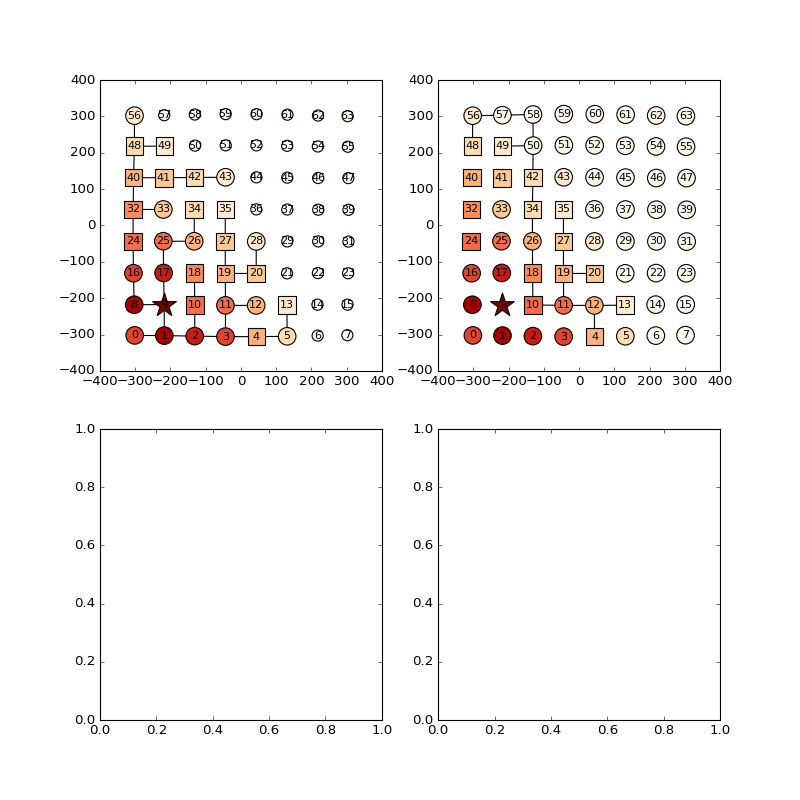

In [9]:
from plot_utils import plot_snapshot
from utils import extract_edges

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 0],
              edges=extract_edges(true_tree))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 1],
              edges=extract_edges(pred_tree))

In [ ]:
ranks = []
for i in tqdm(range(10)):
    infection_times, source, obs_nodes, true_tree = gen_nontrivial_cascade(g, p, q, return_tree=True)
    
    r2tree_size = tree_sizes_by_roots(g, obs_nodes, infection_times, source, 'sync_tbfs')

    winner = np.argmax(r2tree_size)
    tree_source = temporal_bfs_sync(g, source, infection_times, source, obs_nodes, debug=False)
    tree_best = temporal_bfs_sync(g, winner, infection_times, source, obs_nodes, debug=False)
    
    source_rank = get_rank_index(r2tree_size, source)
    ranks.append(source_rank)
    if source_rank >= 10:
        print(r2tree_size[source])
        print(np.sort(r2tree_size))
        print(np.sort(r2tree_size))
        print(np.argsort(r2tree_size))        
        break
        # print(source_rank)    
        # break

In [ ]:
from plot_utils import plot_snapshot

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True, ax=ax[0, 0],
              edges=extract_edges(true_tree))

if True:
    plot_snapshot(gnx, pos, get_infection_time(tree_source, source), queried_nodes=obs_nodes, source_node=source, with_labels=True,
                  ax=ax[0, 1],
                  edges=extract_edges(tree_source))
if True:    
    plot_snapshot(gnx, pos, get_infection_time(tree_best, winner), queried_nodes=obs_nodes, source_node=winner, with_labels=True,
                  ax=ax[1, 0],
                  edges=extract_edges(tree_best))
if True:    
    root = 22
    some_tree = temporal_bfs_sync(g, root, infection_times, source, obs_nodes, debug=False)    
    plot_snapshot(gnx, pos, get_infection_time(some_tree, root), queried_nodes=obs_nodes, source_node=root, with_labels=True,
                  ax=ax[1, 1],
                  edges=extract_edges(some_tree))
    